In [5]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.time
import astropy.units as u
from astropy.visualization import quantity_support, time_support
from sunpy.net import Fido
from sunpy.net import attrs as a
import datetime
import sys
from scipy.signal import savgol_filter
import pandas as pd
import cdflib
import dateutil
import dask.dataframe as dd
from dask.distributed import Client
from scipy.signal import savgol_filter
from scipy import stats
import warnings
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
#from yellowbrick.regressor import CooksDistance

# Read and Treat Data

In [6]:
with open('/efs/sdoradbelt/data/raw_data/Kp_ap_since_1932.txt') as f:
    lines = f.readlines()
i = 0; table = ['T_Obs', 'Days', 'Days_m', 'Kp', 'ap', 'D']; data = []
for line in lines[227950:]: 
    line = line.split(' ')
    while (line.count('')): line.remove('')
    date = datetime.datetime(int(line[0]), int(line[1]), int(line[2]), int(float(line[3])), int(line[4][0:2]), int(line[4][3:]))
    data.append([date,float(line[5]),float(line[6]),float(line[7]),int(line[8]),int(line[9])])
df_kpap = pd.DataFrame(data, columns = table)
df_kpap.set_index('T_Obs', inplace=True)

In [7]:
# Fetch Data
#df_kpap = dd.read_parquet('/efs/sdoradbelt/data/Kp_ap.parquet') # 3h:3m cadence
#df_kpap = pd.DataFrame(df_kpap)
df_sdo = dd.read_parquet("/efs/sdoradbelt/data/sdo_headers", columns=['NSPIKES', 'WAVELNTH','GAEZ_OBS'])
df_sdo = df_sdo.set_index(df_sdo.index, sorted=True) # solve the sorting issue
df_symh = dd.read_parquet('/efs/sdoradbelt/data/symh_etal.parquet') # 1m cadence
df_symh = df_symh.set_index('T_Obs', sorted=True)

In [8]:
# Get headers in all wavelengths, Kp, ap and SymH data. Convert to int32 for less memory. Select time span, cadence and interpolate in case of NaNs.
year_start = 2019; year_end = 2019
month_start = 1; month_end = 12
day_start = 1; day_end = 30
start_d = "{}-{}-{}".format(year_start,str(month_start).zfill(2),str(day_start).zfill(2)); end_d = "{}-{}-{}".format(year_end,str(month_end).zfill(2),str(day_end).zfill(2)) 
cadence = '{}h'.format(3)

In [9]:
lat = df_sdo[df_sdo['WAVELNTH'] == 94]['GAEZ_OBS'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_94 = df_sdo[df_sdo['WAVELNTH'] == 94]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_131 = df_sdo[df_sdo['WAVELNTH'] == 131]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_171 = df_sdo[df_sdo['WAVELNTH'] == 171]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_193 = df_sdo[df_sdo['WAVELNTH'] == 193]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_211 = df_sdo[df_sdo['WAVELNTH'] == 211]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_304 = df_sdo[df_sdo['WAVELNTH'] == 304]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_335 = df_sdo[df_sdo['WAVELNTH'] == 335]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
Kp = df_kpap['Kp'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().interpolate()
ap = df_kpap['ap'].astype(np.int64).loc[start_d:end_d].resample(cadence).mean().interpolate()
symh = df_symh['Sym_H'].astype(np.int64).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()

In [10]:
# Normalization (Savitzky-Golay)
normalize = False
if normalize == True:
    window_len = 80; polyorder = 8
    nspikes_94 = savgol_filter(nspikes_94,window_len,polyorder); nspikes_131 = savgol_filter(nspikes_131,window_len,polyorder)
    nspikes_171 = savgol_filter(nspikes_171,window_len,polyorder); nspikes_193 = savgol_filter(nspikes_193,window_len,polyorder)
    nspikes_211 = savgol_filter(nspikes_211,window_len,polyorder); nspikes_304 = savgol_filter(nspikes_304,window_len,polyorder)
    nspikes_335 = savgol_filter(nspikes_335,window_len,polyorder)

# Plot Timelines

In [11]:
# Notes: 
# POINT OUT THE NEGATIVE CORRELATION IN THE PAPER
# DISCUSS A BIT NORMALIZATION BUT MAYBE NOT INCLUDE IT (DO LAST DEPENDING ON LENGTH)
# Best year Correlation is 2019 / best month: 

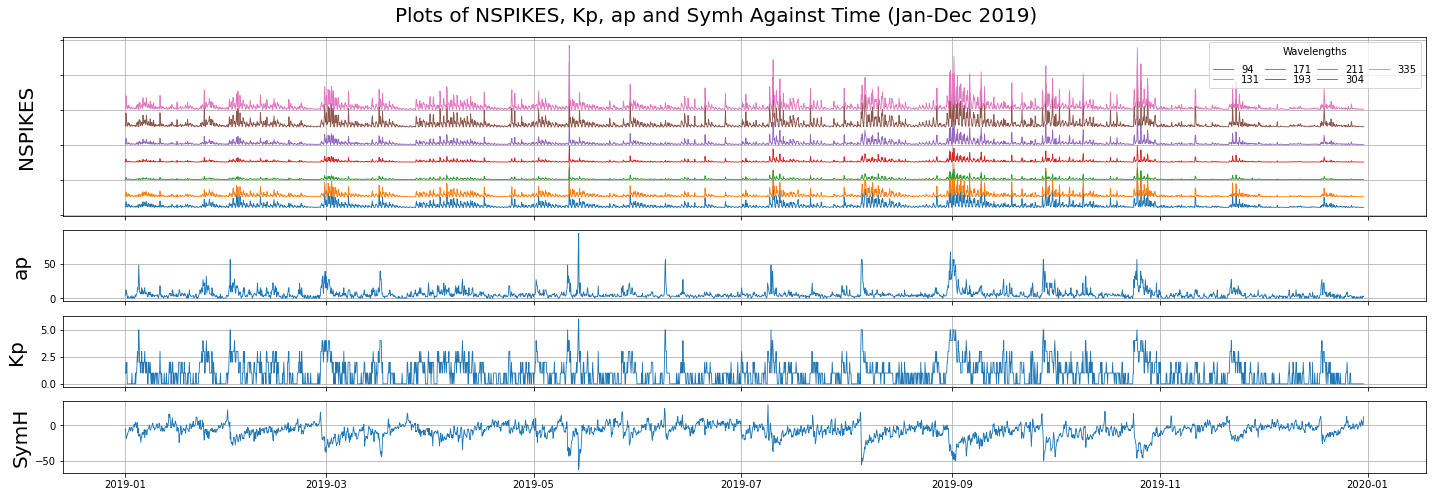

In [12]:
#plot NSPIKES:
fig, axs = plt.subplots(4,1,figsize=(20,7),gridspec_kw={'height_ratios': [2.5,1,1,1]})
lw = 0.85
fig.suptitle('Plots of NSPIKES, Kp, ap and Symh Against Time (Jan-Dec 2019)',fontsize=20)
axs[0].plot(nspikes_94+1e5,linewidth=lw,label='94'); axs[0].plot(nspikes_131+2.5*1e5,linewidth=lw,label='131')
axs[0].plot(nspikes_171+5*1e5,linewidth=lw,label='171'), axs[0].plot(nspikes_193+7.5*1e5,linewidth=lw,label='193')
axs[0].plot(nspikes_211+10*1e5,linewidth=lw,label='211'); axs[0].plot(nspikes_304+12.5*1e5,linewidth=lw,label='304')
axs[0].plot(nspikes_335+15*1e5,linewidth=lw,label='335')
axs[0].set_xticklabels([]); axs[0].set_yticklabels([])
axs[0].set_ylabel('NSPIKES', fontsize=20, labelpad=20)
axs[0].grid()
legend = axs[0].legend(title='Wavelengths',fancybox=True, fontsize=10, labelspacing=0, columnspacing=0.5, 
              ncol=4, loc='upper right', markerscale=300, title_fontsize=10)
legend._legend_box.sep = 8; #legend.legendHandles[0]._legmarker.set_markersize(15)

#plot ap:
axs[1].plot(ap,linewidth=lw)
axs[1].set_xticklabels([])
axs[1].set_ylabel('ap', fontsize=20, labelpad=13)
axs[1].grid()

#plot Kp:
axs[2].plot(Kp,linewidth=lw)
axs[2].grid()
axs[2].set_xticklabels([])
axs[2].set_ylabel('Kp', fontsize=20, labelpad=14)

#plot Kp-Ap:
axs[3].plot(symh,linewidth=lw)
axs[3].set_ylabel('SymH', fontsize=20)
axs[3].grid()

fig.tight_layout()
plt.savefig('NSPIKES_Geomag_timeline.png')
plt.show()

In [20]:
print(stats.pearsonr(nspikes_335,ap)[0])
print(stats.spearmanr(nspikes_335,ap)[0])
print(stats.pearsonr(nspikes_335,Kp)[0])
print(stats.spearmanr(nspikes_335,Kp)[0])
print(stats.pearsonr(nspikes_335,symh)[0])
print(stats.spearmanr(nspikes_335,symh)[0])

0.373713393337799
0.39278736165842193
0.3913695489996088
0.37490713421982624
-0.4213270562758147
-0.37590825394398353


In [21]:
# Get headers in all wavelengths, Kp, ap and SymH data. Convert to int32 for less memory. Select time span, cadence and interpolate in case of NaNs.
year_start = 2019; year_end = 2019
month_start = 2; month_end = 2 #8 is good
day_start = 1; day_end = 28
start_d = "{}-{}-{}".format(year_start,str(month_start).zfill(2),str(day_start).zfill(2)); end_d = "{}-{}-{}".format(year_end,str(month_end).zfill(2),str(day_end).zfill(2)) 
cadence = '{}h'.format(3)

In [22]:
lat_m = df_sdo[df_sdo['WAVELNTH'] == 94]['GAEZ_OBS'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_94_m = df_sdo[df_sdo['WAVELNTH'] == 94]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_131_m = df_sdo[df_sdo['WAVELNTH'] == 131]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_171_m = df_sdo[df_sdo['WAVELNTH'] == 171]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_193_m = df_sdo[df_sdo['WAVELNTH'] == 193]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_211_m = df_sdo[df_sdo['WAVELNTH'] == 211]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_304_m = df_sdo[df_sdo['WAVELNTH'] == 304]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_335_m = df_sdo[df_sdo['WAVELNTH'] == 335]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
Kp_m = df_kpap['Kp'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().interpolate()
ap_m = df_kpap['ap'].astype(np.int64).loc[start_d:end_d].resample(cadence).mean().interpolate()
symh_m = df_symh['Sym_H'].astype(np.int64).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()

In [23]:
print(stats.pearsonr(nspikes_335_m,Kp_m)[0])
print(stats.spearmanr(nspikes_335_m,Kp_m)[0])
print(stats.pearsonr(nspikes_335_m,ap_m)[0])
print(stats.spearmanr(nspikes_335_m,ap_m)[0])
print(stats.pearsonr(nspikes_335_m,symh_m)[0])
print(stats.spearmanr(nspikes_335_m,symh_m)[0])

0.5186109222664046
0.5331995285532972
0.5037292430552752
0.5340868241678318
-0.45565966958176907
-0.4573537572573029


In [ ]:
#plot NSPIKES:
fig, axs = plt.subplots(4,1,figsize=(9,5),gridspec_kw={'height_ratios': [2,1,1,1]})
lw = 1; yaxis_font_size = 10
#fig.suptitle('Plots of NSPIKES, Kp, ap and Symh Against Time (Jan-Dec 2019)',fontsize=20)
axs[0].plot(nspikes_94_m+1e5,linewidth=lw,label='94'); axs[0].plot(nspikes_131_m+2*1e5,linewidth=lw,label='131')
axs[0].plot(nspikes_171_m+3*1e5,linewidth=lw,label='171'), axs[0].plot(nspikes_193_m+4*1e5,linewidth=lw,label='193')
axs[0].plot(nspikes_211_m+5*1e5,linewidth=lw,label='211'); axs[0].plot(nspikes_304_m+6*1e5,linewidth=lw,label='304')
axs[0].plot(nspikes_335_m+7*1e5,linewidth=lw,label='335')
axs[0].set_xticklabels([]); axs[0].set_yticklabels([])
axs[0].set_ylabel('NSPIKES', fontsize=yaxis_font_size, labelpad=25)
axs[0].grid()
for axis in ['top','bottom','left','right']: axs[0].spines[axis].set_linewidth(0.5)
#legend = axs[0].legend(title='Wavelengths',fancybox=True, fontsize=8, labelspacing=0, columnspacing=0.5, 
              #ncol=4, loc='upper right', markerscale=300, title_fontsize=8)
#legend._legend_box.sep = 8; #legend.legendHandles[0]._legmarker.set_markersize(15)

#plot ap:
axs[1].plot(ap_m,linewidth=lw)
axs[1].set_xticklabels([])
axs[1].set_ylabel('ap', fontsize=yaxis_font_size, labelpad=13)
axs[1].grid()
for axis in ['top','bottom','left','right']: axs[1].spines[axis].set_linewidth(0.5)

#plot Kp:
axs[2].plot(Kp_m,linewidth=lw)
axs[2].grid()
axs[2].set_xticklabels([])
axs[2].set_ylabel('Kp', fontsize=yaxis_font_size, labelpad=10)
for axis in ['top','bottom','left','right']: axs[2].spines[axis].set_linewidth(0.5)

#plot Kp-Ap:
axs[3].plot(symh_m,linewidth=lw)
axs[3].set_ylabel('SymH', fontsize=yaxis_font_size)
axs[3].grid()
for axis in ['top','bottom','left','right']: axs[3].spines[axis].set_linewidth(0.5)

fig.tight_layout()
plt.xticks(fontsize=8)
plt.savefig('NSPIKES_Geomag_timeline_zoom.png')
plt.show()

# Time Shift

In [ ]:
nspikes_all = [nspikes_94,nspikes_131,nspikes_171,nspikes_193,nspikes_211,nspikes_304,nspikes_335]
i = 1

for spike in nspikes_all:

    time_shift = []; r_ap = []; r_kp = []; r_symh = []
    nspikes_r = spike; ap_r = ap; Kp_r = Kp; symh_r = symh
    for i in range(1,7):
        nspikes_r = nspikes_r.drop(nspikes_r.index[0])
        ap_r = ap_r.drop(ap_r.index[-1])
        Kp_r = Kp_r.drop(Kp_r.index[-1])
        symh_r = symh_r.drop(symh_r.index[-1])
        time_shift.append(i*3)
        r_ap.append(stats.pearsonr(nspikes_r,ap_r)[0])
        r_kp.append(stats.pearsonr(nspikes_r,Kp_r)[0])
        r_symh.append(stats.pearsonr(nspikes_r,symh_r)[0])

    nspikes_r = spike; ap_r = ap; Kp_r = Kp; symh_r = symh
    time_shift_n = []; r_ap_n = []; r_kp_n = []; r_symh_n = []
    for i in range(1,7):
        nspikes_r = nspikes_r.drop(nspikes_r.index[-1])
        ap_r = ap_r.drop(ap_r.index[0])
        Kp_r = Kp_r.drop(Kp_r.index[0])
        symh_r = symh_r.drop(symh_r.index[0])
        time_shift_n.append(i*3)
        r_ap_n.append(stats.pearsonr(nspikes_r,ap_r)[0])
        r_kp_n.append(stats.pearsonr(nspikes_r,Kp_r)[0])
        r_symh_n.append(stats.pearsonr(nspikes_r,symh_r)[0])

    time_shift_n = [ -x for x in time_shift_n]
    t_shift = list(reversed(time_shift_n)) + [0] + time_shift
    ap_shift = list(reversed(r_ap_n)) + [stats.pearsonr(nspikes_171,ap)[0]] + r_ap
    kp_shift = list(reversed(r_kp_n)) + [stats.pearsonr(nspikes_171,Kp)[0]] + r_kp
    symh_shift = list(reversed(r_symh_n)) + [stats.pearsonr(nspikes_171,symh)[0]] + r_symh
    symh_shift = [ -x for x in symh_shift]

    plt.plot(t_shift,ap_shift,label = r'$r_{ap}$',color='blue')
    plt.plot(t_shift,kp_shift,label = r'$r_{Kp}$',color='orange')
    plt.plot(t_shift,symh_shift,label = r'$-r_{SymH}$',color='green')
    if i == 7:
        plt.plot(t_shift,ap_shift,label = r'$r_{ap}$',color='blue')
        plt.plot(t_shift,kp_shift,label = r'$r_{Kp}$',color='orange')
        plt.plot(t_shift,symh_shift,label = r'$-r_{SymH}$',color='green')
    plt.xlabel('Time Shift (h)')
    plt.ylabel('Pearson Correlation (r)')
    plt.title('Correlation between NSPIKES and Geomagnetic Parameters for different Time Shifts',fontsize=9, pad=13)
    i += 1
    
plt.legend(loc='lower right',fontsize=14)
plt.savefig('NSPIKES_Geomag_time_shift.png')
plt.grid()
plt.figure(figsize=(7,4))
plt.show()

# Total Correlation Table

In [ ]:
r11a=[];r12a=[];r13a=[];r21a=[];r22a=[];r23a=[];r31a=[];r32a=[];r33a=[];r41a=[]
r42a=[];r43a=[];r51a=[];r52a=[];r53a=[];r61a=[];r62a=[];r63a=[];r71a=[];r72a=[];r73a=[]
for year in range(2011,2021):
    print(year)
    # 3 HOURS CADENCE (per year)
    # Get headers in all wavelengths, Kp, ap and SymH data. Convert to int32 for less memory. Select time span, cadence and interpolate in case of NaNs.
    year_start = year; year_end = year
    month_start = 1; month_end = 12
    day_start = 1; day_end = 30
    start_d = "{}-{}-{}".format(year_start,str(month_start).zfill(2),str(day_start).zfill(2)); end_d = "{}-{}-{}".format(year_end,str(month_end).zfill(2),str(day_end).zfill(2)) 
    cadence = '{}h'.format(3)
    lat = df_sdo[df_sdo['WAVELNTH'] == 94]['GAEZ_OBS'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
    nspikes_94 = df_sdo[df_sdo['WAVELNTH'] == 94]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
    nspikes_131 = df_sdo[df_sdo['WAVELNTH'] == 131]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
    nspikes_171 = df_sdo[df_sdo['WAVELNTH'] == 171]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
    nspikes_193 = df_sdo[df_sdo['WAVELNTH'] == 193]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
    nspikes_211 = df_sdo[df_sdo['WAVELNTH'] == 211]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
    nspikes_304 = df_sdo[df_sdo['WAVELNTH'] == 304]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
    nspikes_335 = df_sdo[df_sdo['WAVELNTH'] == 335]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
    Kp = df_kpap['Kp'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().interpolate()
    ap = df_kpap['ap'].astype(np.int64).loc[start_d:end_d].resample(cadence).mean().interpolate()
    symh = df_symh['Sym_H'].astype(np.int64).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
    r11 = stats.spearmanr(nspikes_94,Kp)[0]; r12 = stats.spearmanr(nspikes_94,ap)[0]; r13 = np.abs(stats.spearmanr(nspikes_94,symh)[0])
    r21 = stats.spearmanr(nspikes_131,Kp)[0]; r22 = stats.spearmanr(nspikes_131,ap)[0]; r23 = np.abs(stats.spearmanr(nspikes_131,symh)[0])
    r31 = stats.spearmanr(nspikes_171,Kp)[0]; r32 = stats.spearmanr(nspikes_171,ap)[0]; r33 = np.abs(stats.spearmanr(nspikes_171,symh)[0])
    r41 = stats.spearmanr(nspikes_193,Kp)[0]; r42 = stats.spearmanr(nspikes_193,ap)[0]; r43 = np.abs(stats.spearmanr(nspikes_193,symh)[0])
    r51 = stats.spearmanr(nspikes_211,Kp)[0]; r52 = stats.spearmanr(nspikes_211,ap)[0]; r53 = np.abs(stats.spearmanr(nspikes_211,symh)[0])
    r61 = stats.spearmanr(nspikes_304,Kp)[0]; r62 = stats.spearmanr(nspikes_304,ap)[0]; r63 = np.abs(stats.spearmanr(nspikes_304,symh)[0])
    r71 = stats.spearmanr(nspikes_335,Kp)[0]; r72 = stats.spearmanr(nspikes_335,ap)[0]; r73 = np.abs(stats.spearmanr(nspikes_335,symh)[0])
    print(r11,r12,r13)
    print(r21,r22,r23)
    print(r31,r32,r33)
    print(r41,r42,r43)
    print(r51,r52,r53)
    print(r61,r62,r63)
    print(r71,r72,r73)
    r11a.append(r11);r12a.append(r12);r13a.append(r13)
    r21a.append(r21);r22a.append(r22);r23a.append(r23)
    r31a.append(r31);r32a.append(r32);r33a.append(r33)
    r41a.append(r41);r42a.append(r42);r43a.append(r43)
    r51a.append(r51);r52a.append(r52);r53a.append(r53)
    r61a.append(r61);r62a.append(r62);r63a.append(r63)
    r71a.append(r71);r72a.append(r72);r73a.append(r73)

In [ ]:
print('means')
print(round(np.mean(r11a),3),round(np.mean(r12a),3),round(np.mean(r13a),3))
print(round(np.mean(r21a),3),round(np.mean(r22a),3),round(np.mean(r23a),3))
print(round(np.mean(r31a),3),round(np.mean(r32a),3),round(np.mean(r33a),3))
print(round(np.mean(r41a),3),round(np.mean(r42a),3),round(np.mean(r43a),3))
print(round(np.mean(r51a),3),round(np.mean(r52a),3),round(np.mean(r53a),3))
print(round(np.mean(r61a),3),round(np.mean(r62a),3),round(np.mean(r63a),3))
print(round(np.mean(r71a),3),round(np.mean(r72a),3),round(np.mean(r73a),3))

In [ ]:
print('stds')
print(round(np.std(r11a),3),round(np.std(r12a),3),round(np.std(r13a),3))
print(round(np.std(r21a),3),round(np.std(r22a),3),round(np.std(r23a),3))
print(round(np.std(r31a),3),round(np.std(r32a),3),round(np.std(r33a),3))
print(round(np.std(r41a),3),round(np.std(r42a),3),round(np.std(r43a),3))
print(round(np.std(r51a),3),round(np.std(r52a),3),round(np.std(r53a),3))
print(round(np.std(r61a),3),round(np.std(r62a),3),round(np.std(r63a),3))
print(round(np.std(r71a),3),round(np.std(r72a),3),round(np.std(r73a),3))

# Create Arrays and Split to Training and Testing

In [ ]:
# Get headers in all wavelengths, Kp, ap and SymH data. Convert to int32 for less memory. Select time span, cadence and interpolate in case of NaNs.
year_start = 2010; year_end = 2020
month_start = 8; month_end = 1
day_start = 1; day_end = 30
start_d = "{}-{}-{}".format(year_start,str(month_start).zfill(2),str(day_start).zfill(2)); end_d = "{}-{}-{}".format(year_end,str(month_end).zfill(2),str(day_end).zfill(2)) 
cadence = '{}h'.format(3)

In [ ]:
lat = df_sdo[df_sdo['WAVELNTH'] == 94]['GAEZ_OBS'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_94 = df_sdo[df_sdo['WAVELNTH'] == 94]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_131 = df_sdo[df_sdo['WAVELNTH'] == 131]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_171 = df_sdo[df_sdo['WAVELNTH'] == 171]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_193 = df_sdo[df_sdo['WAVELNTH'] == 193]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_211 = df_sdo[df_sdo['WAVELNTH'] == 211]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_304 = df_sdo[df_sdo['WAVELNTH'] == 304]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_335 = df_sdo[df_sdo['WAVELNTH'] == 335]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
Kp = df_kpap['Kp'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().interpolate()
ap = df_kpap['ap'].astype(np.int64).loc[start_d:end_d].resample(cadence).mean().interpolate()
symh = df_symh['Sym_H'].astype(np.int64).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()

In [ ]:
# Brind to numpy
x = np.stack((nspikes_94, nspikes_94)) #np.stack((nspikes_94_eq, nspikes_131_eq, nspikes_171_eq, nspikes_193_eq, nspikes_211_eq, nspikes_304_eq, nspikes_335_eq))
x[np.where(x < 1)] = 1
x = np.log(x)
y = -np.array(symh)
y = y + np.abs(np.min(y)) + 1
y = np.log(y)

#x = np.stack((nspikes_94, nspikes_131, nspikes_171, nspikes_193, nspikes_211, nspikes_304, nspikes_335))
#y = np.array(ap)

In [ ]:
# Split Training and Testing
train_test_ratio = 0.9
x_train  = x[:,0:int(0.9*np.shape(x)[1])]
x_val = x[:,int(0.9*np.shape(x)[1]):]
y_train = y[0:int(0.9*np.shape(x)[1])]
y_val = y[int(0.9*np.shape(x)[1]):]

In [ ]:
# Get rid of corrupt data (if any)
x_train[x_train<0] = 0
x_val[x_val<0] = 0

# Build Linear Regression Model (one wavelength)

In [ ]:
wl_idx = 1
model = LinearRegression(normalize=False)
model.fit(x_train[wl_idx,:].reshape(-1, 1), y_train.reshape(-1, 1))
predictions = model.predict(x_val[wl_idx,:].reshape(-1, 1))
#influence = model.get_influence()
(slope, intercept) = (model.coef_[0], model.intercept_)
x_fit = np.linspace(0,np.max(x_train[wl_idx,:]),100)
y_fit = slope*x_fit+intercept
print(slope, intercept)

# Visualize Linear Regression Results

In [ ]:
# Heatmaps
#grid(False)
#plt.style.use('bmh')
figure, axis = plt.subplots(1, 2, figsize=(18,6),gridspec_kw={'width_ratios': [0.825,1]})
figure.suptitle('Regression Model Fit', fontsize=18, x = 0.475)

#axis[1].hist2d(x_train[wl_idx,:], y_train, bins=125, cmap=plt.cm.jet)
axis[0].plot(x_fit, y_fit, '-r')
axis[0].scatter(x_val[wl_idx,:], y_val, s = 3, c = 'rebeccapurple')
axis[0].set_xlim(7.25,13) #set_xlim(np.min(x_train[wl_idx,:]),0.2*np.max(x_train[wl_idx,:]))
axis[0].set_ylim(4,5.2) #set_ylim(np.min(y_train),0.2*np.max(y_train))
axis[0].set_xlabel('log(NSPIKES)')
#axis[1].grid()
axis[0].set_facecolor('white')
axis[0].set_ylabel('log(Sym-H - min(SymH))')
axis[0].title.set_text('Testing Data Scatter Plot')

h = axis[1].hist2d(x_train[wl_idx,:], y_train, bins=300, cmap=plt.cm.BuPu)
#hh = ax.hist2d(x, y, bins=40, norm=colors.LogNorm())
figure.colorbar(h[3], ax=axis[1], pad = 0.018)
axis[1].plot(x_fit, y_fit, '-r',label='Regression Line')
#axis[0].scatter(x_val[wl_idx,:], y_val, s = 2, c = 'pink')
axis[1].set_xlim(6.75,13) #set_xlim(np.min(x_train[wl_idx,:]),0.2*np.max(x_train[wl_idx,:]))
axis[1].set_ylim(4,5.2) #set_ylim(np.min(y_train),0.2*np.max(y_train))
axis[1].set_xlabel('log(NSPIKES)')
axis[1].set_yticklabels([])
axis[1].title.set_text('Training Data Histogram')

plt.legend(fontsize=15)
plt.subplots_adjust(wspace=0.02)
plt.savefig('NSPIKES_Geomag_regression_fit.png')
plt.show()

# Evaluate Linear Regressions

In [ ]:
# Mean Squared Error
print('Mean Squared Error: {}'.format(round(mean_squared_error(y_val, predictions),3)))
# R2 Score
print('R2 Score {}'.format(round(r2_score(y_val, predictions),3))) #A score of 1 is the perfect score and indicates that all the variance is explained by the independent variables. A score of 0 would indicate that the independent variables don't explain any of the variance. A negative score below 0 indicates that the independent variables aren't explaining the variance and are actually contributing negatively to the model

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(18,6),gridspec_kw={'width_ratios': [1,1]})
#figure.suptitle('Regression Model Fit', fontsize=18)

axis[0].set_facecolor('white')
residual = np.subtract(y_val.reshape(-1, 1),predictions)
axis[0].scatter(predictions,residual,s = 3,color='r',label='Training Data')
axis[0].axhline(0, color='black')
axis[0].set_xlim([4.477,4.65])
axis[0].set_title('Residual Plot (Testing Data)',size=12)
axis[0].set_xlabel('Predicted Values')
axis[0].set_ylabel('Residual')

#fig, ax = plt.subplots(nrows=1, ncols=1)
axis[1].set_facecolor('white')
visualizer = CooksDistance()
visualizer.fit(x_train[wl_idx,:].reshape(-1, 1), y_train)
axis[1].set_title('Cooks Distance for Outlier Detection (Training Data)',size=12)
axis[1].set_xlabel('Instance Index')
axis[1].set_ylim([0,0.0025])
axis[1].set_ylabel('Influence')

plt.legend(fontsize=12)
plt.savefig('NSPIKES_Geomag_regression_statistics.png')
plt.show()